In [1]:
import gc
gc.collect()

0

In [20]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import sklearn
import sys
import scipy
import bbknn
from scanpy.tools import leiden
from collections import Counter
import scanpy.logging as logg
import functools
from datetime import datetime
import matplotlib.pyplot as pl
from matplotlib import rcParams

##定义函数
def timestamp():
    """
    Returns current time in format: YYYY-MM-DDThh-mm-ss
    """
    return datetime.now().strftime("%Y-%m-%dT%H-%M-%S")

#
def datestamp():
    return datetime.now().strftime("%Y%m%d")
#
def play_nice_with_categories(has_int=False):
    """
    Any function that modifies a dataframe categorical dataframe column, e.g.
    `adata.obs['cluster']`, will first have the column transformed to 'object' dtype (or
    optionally 'int' dtype) for it to operate on and return.  The returning column will
    then be transformed into an ordered categorical column again.
    """
    def decorator_play_nice_with_categories(func):
        @functools.wraps(func)
        def wrapper(df, *args, **kwargs):
            """
            expects just a single adata.obs[key] column
            """
            df = df.astype("str")
            if has_int:
                df = df.astype("int")
            new_df = func(df, *args, **kwargs)
            new_df = new_df.astype("str").astype("category")
            if has_int:
                new_df.cat.reorder_categories(
                    new_df.cat.categories.astype(int).sort_values().astype(str),
                    inplace=True
                )
            return new_df
        return wrapper
    return decorator_play_nice_with_categories

@play_nice_with_categories(has_int=True)
def shift_clusters(obs):
    if obs.min() == 0:
        obs += 1
    return obs

@play_nice_with_categories(has_int=True)
def order_clusters(obs):
    return obs

@play_nice_with_categories(has_int=True)
def reset_int_category(obs):
    uniq = sorted(obs.unique())
    new_ints = np.arange(1, len(uniq) + 1, dtype=int)
    mapping = dict(zip(uniq, new_ints))
    return obs.map(mapping)

__api_objects__ = {
    "datestamp": datestamp,
    "timestamp": timestamp,
}


def subcluster(adata_filt, cluster, resolution=0.4, cluster_key="cluster"):
    dtype = adata_filt.obs[cluster_key].dtype
    if dtype in ("object", str, pd.api.types.CategoricalDtype):
        cluster = str(cluster)
    #else:
    #    cluster = int(cluster)

    if cluster_key[-1].isdigit():
        base, version = cluster_key.split("_R")
        key_added = f"{base}_R{int(version)+1}"
    else:
        key_added = f"{cluster_key}_R1"
    leiden(
        adata_filt,
        resolution=resolution,
        key_added=key_added,
        restrict_to=(cluster_key, [cluster]),
    )

    # we want to preserve the ordering of old clusters and just add more.
    all_new_clusters = adata_filt.obs[key_added].cat.categories
    just_new_clusters = all_new_clusters[all_new_clusters.str.startswith(cluster)]
    if len(just_new_clusters) == 1:
        logg.warning(f"Wasn't able to subcluster with resolution `{resolution}`].")
        logg.warning(f"You may try increasing the resolution.")
        logg.warning(f"Returning `adata` with original clusters under `{cluster_key}`.")
        adata_filt.obs.drop(key_added, axis=1, inplace=True)
        return

    old_max = adata_filt.obs[cluster_key].astype(int).max()

    tmp = pd.DataFrame()
    tmp["old"] = adata_filt.obs[cluster_key].astype("object")
    tmp["tmp"] = adata_filt.obs[key_added].astype("object")
    tmp["suff"] = adata_filt.obs[key_added].str.extract(",(\d+)", expand=False)
    tmp["new"] = tmp.old
    remapper = lambda row: row.old if row.suff == "0" else str(old_max + int(row.suff))
    tmp.loc[tmp.old != tmp.tmp, "new"] = tmp.loc[tmp.old != tmp.tmp].apply(
        remapper, axis=1
    )

    #adata_filt.obs[key_added] = tmp["new"].astype(str).astype("category")
    adata_filt.obs[key_added] = order_clusters(tmp["new"])
    #order_clusters(adata_filt, key_added)
    logg.info(f"Updated clusters under `adata_redux.obs['{key_added}']`.")

############################
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# 

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


AnnData object with n_obs × n_vars = 55873 × 31994
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'case_barcode', 'case_sex', 'age_at_resection', 'tumor_location', 'laterality', 'time_point', 'idh_codel_subtype', 'who_grade', 'histological_classification', 'cells_sc_10X', 'cells_sc_rrbs', 'mnp_classification_epic', 'verhaak_classification_rna', 'mutations_per_megabase', 'somatic_copy_number_alt_burden', 'driver_mutations', 'percent.mt', 'percent.HB', 'S.Score', 'G2M.Score', 'Phase'
                           orig.ident  nCount_RNA  nFeature_RNA case_barcode  \
index                                                                          
RV19002_AAACCCAAGCGTGCTC-1      SM006      5401.0          2292        SM006   
RV19002_AAACCCAAGTCTTCGA-1      SM006     12843.0          5027        SM006   
RV19002_AAACCCACAAAGGTTA-1      SM006     18952.0          5921        SM006   
RV19002_AAACCCACAAGGCGTA-1      SM006     12329.0          3515        SM006   
RV19002_AAACCCAGTACGGGAT-1 

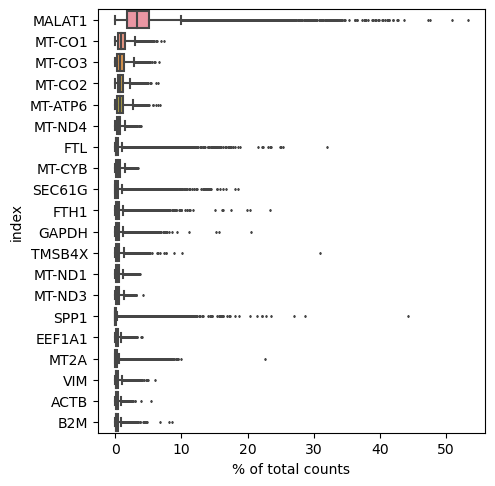

filtered out 28 cells that have less than 300 genes expressed
filtered out 715 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 55845 × 31279
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'case_barcode', 'case_sex', 'age_at_resection', 'tumor_location', 'laterality', 'time_point', 'idh_codel_subtype', 'who_grade', 'histological_classification', 'cells_sc_10X', 'cells_sc_rrbs', 'mnp_classification_epic', 'verhaak_classification_rna', 'mutations_per_megabase', 'somatic_copy_number_alt_burden', 'driver_mutations', 'percent.mt', 'percent.HB', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'n_cells'

In [21]:
adata = sc.read_h5ad("/media/4T_disk/scRNA_10X_data_human/10X_human_T_merge/data/merge/scobj_GSE139448_verhaak_GSE223063.h5ad")
print(adata)
print(adata.obs)
adata.uns
#
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
adata
#

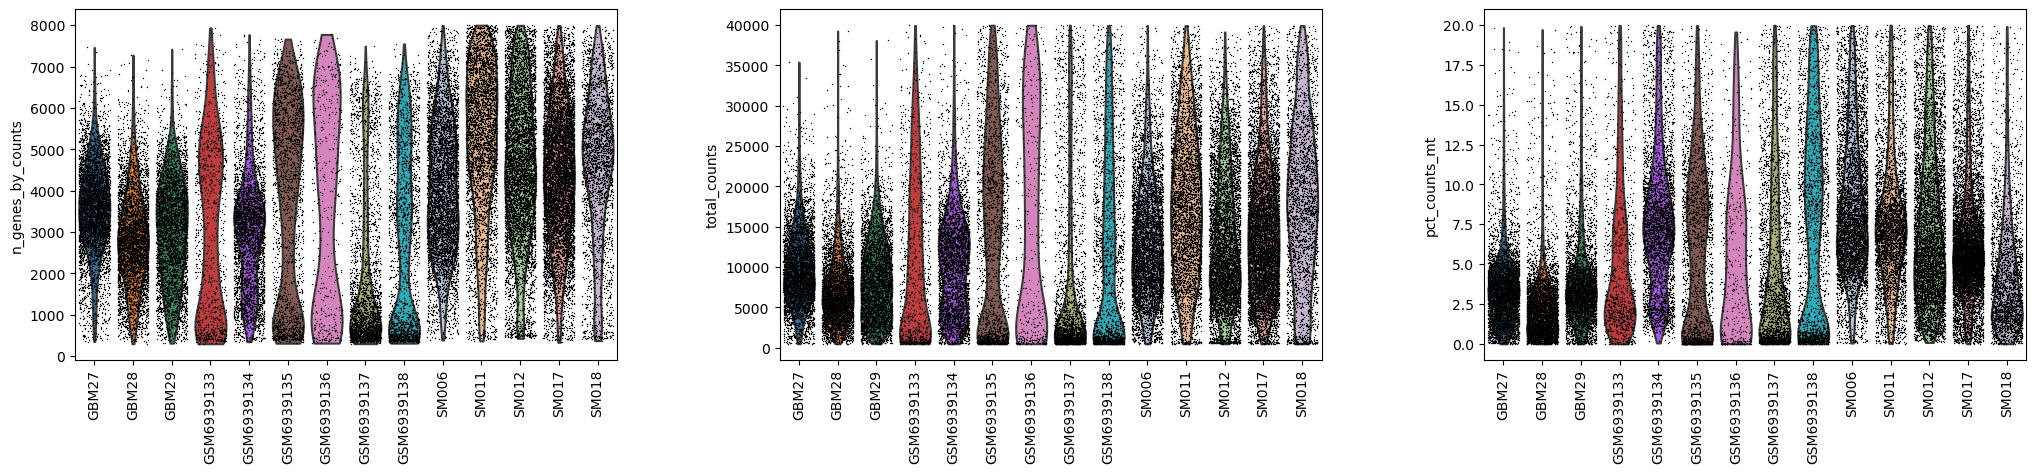

In [23]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # 将线粒体基因标记为 mt
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True,groupby= "orig.ident",rotation=90)
#sc.pl.violin(adata, ['sequencing_saturation', 'scrublet_predicted_doublets', 'pct_counts_mitochondrial'],jitter=0.4, multi_panel=True,groupby= "sampleid")
#

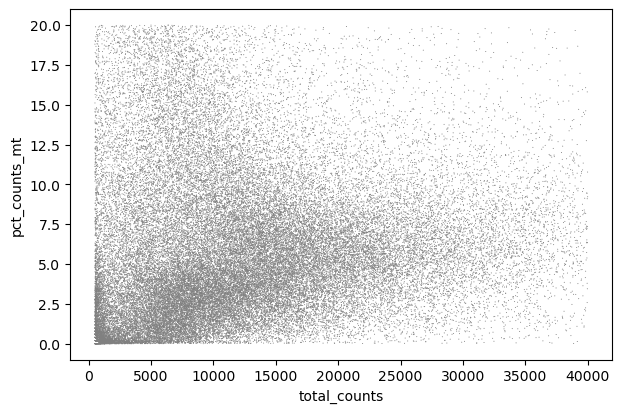

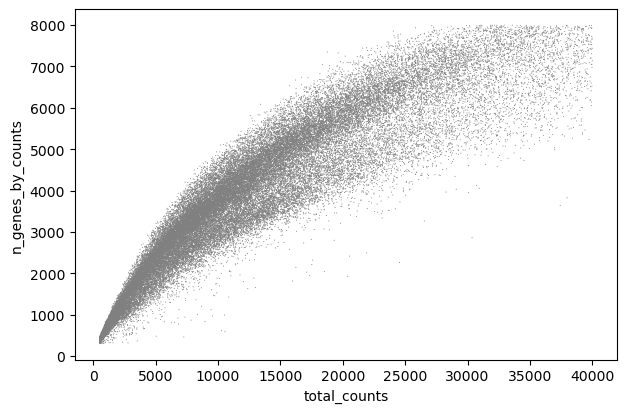

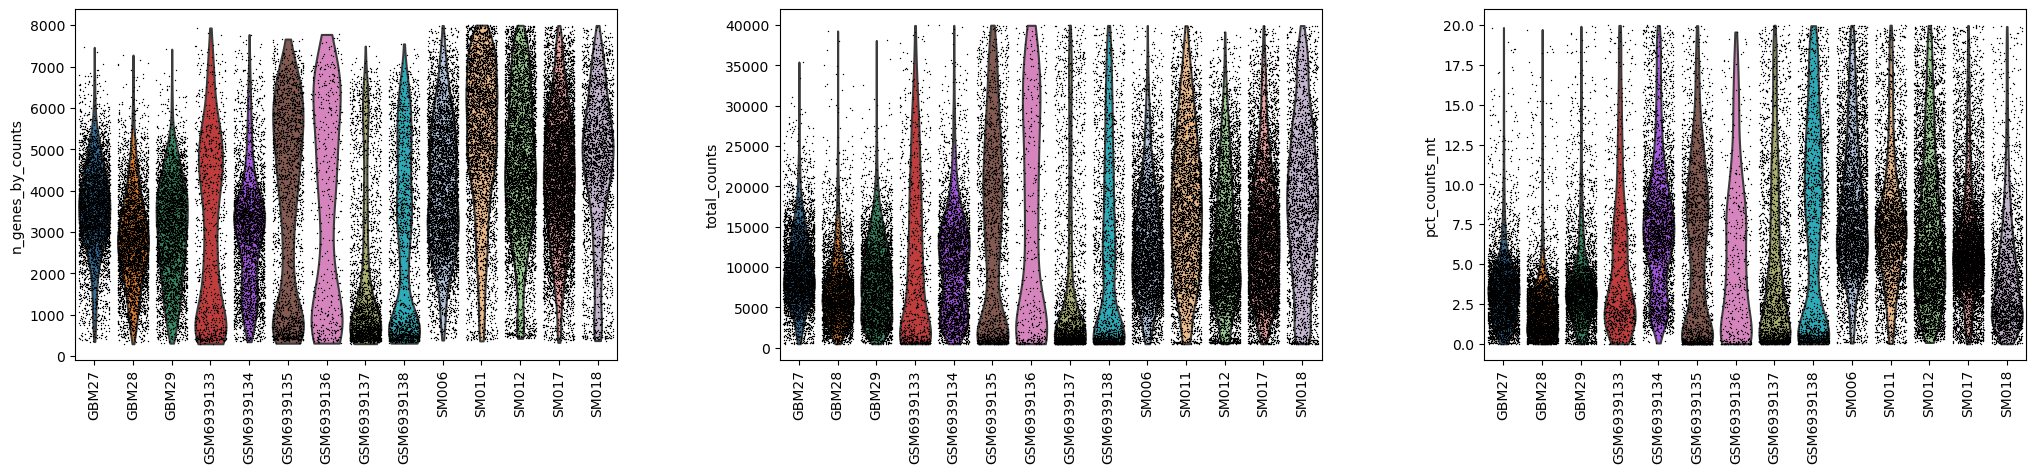

/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:01)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


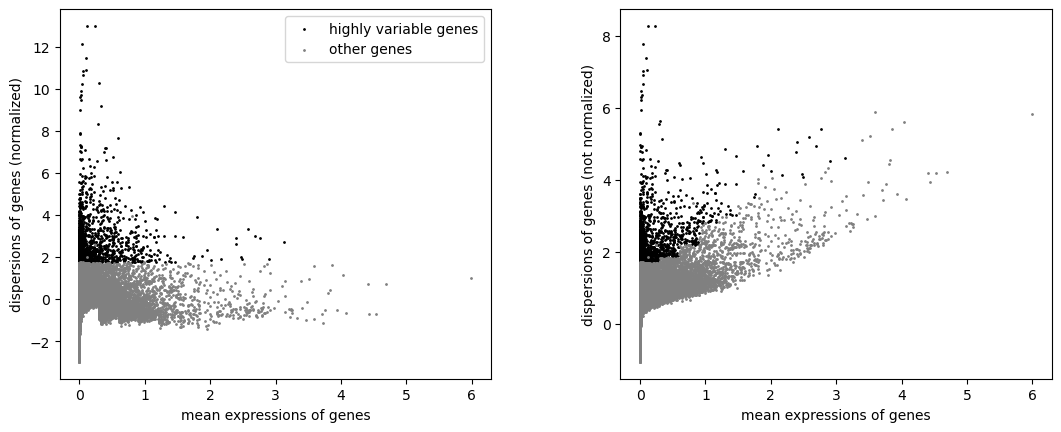

Counter({False: 29782, True: 1497})

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
#过滤线粒体表达量高的细胞
adata = adata[adata.obs['pct_counts_mt'] < 30, :]
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True,groupby= "orig.ident",rotation=90)
#数据标准化 总计数归一化、对数化  , target_sum=1e6  •如果使用target_sum=1e6，那么相当于CPM标准化。
# 原始reads除以样品总的可用reads数乘以 1,000,000 获得每百万reads的count数 (counts per million (__CPM__)
adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata
# 识别高度可变的基因
sc.pp.highly_variable_genes(adata, n_top_genes=1500)
#import scanpy_recipes
#from scanpy_recipes.recipes.qc import read_hemoglobin_file, read_mito_file
mito_genes = ["MT-TF", "MT-RNR1", "MT-TV", "MT-RNR2", "MT-TL1", "MT-ND1","MT-TI", "MT-TQ", "MT-TM", "MT-ND2", "MT-TW", "MT-TA", "MT-TN","MT-TC", "MT-TY", "MT-CO1", "MT-TS1", "MT-TD", "MT-CO2", "MT-TK","MT-ATP8", "MT-ATP6", "MT-CO3", "MT-TG", "MT-ND3", "MT-TR", "MT-ND4L","MT-ND4", "MT-TH", "MT-TS2", "MT-TL2", "MT-ND5", "MT-ND6", "MT-TE","MT-CYB", "MT-TT", "MT-TP"]

hemo_genes = ["HBA1", "HBA2", "HBB", "HBD", "HBE1", "HBG1", "HBG2", "HBM", "HBQ1", "HBZ"]

adata.var["hemoglobin"] = adata.var_names.isin(hemo_genes)
adata.var['mitochondrial'] = adata.var_names.isin(mito_genes)

adata.var.loc[adata.var.mitochondrial|adata.var.hemoglobin, "highly_variable"] = False
adata.var.groupby(['highly_variable','hemoglobin', 'mitochondrial']).size()

sc.pl.highly_variable_genes(adata)
# 保存原始数据
adata.raw = adata
# 过滤
#adata = adata[:, adata.var.highly_variable]
Counter(adata.var.highly_variable)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:33)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)


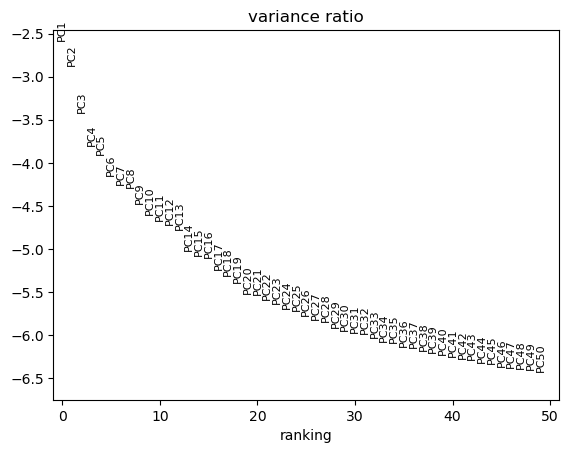

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:39)


In [25]:
# 将数据缩放到单位方差,回归线粒体和测序深度, ['total_counts', 'pct_counts_mt']
sc.pp.regress_out(adata,['total_counts', 'pct_counts_mt'], n_jobs=38)
sc.pp.scale(adata, max_value=10)
#通过运行主成分分析(PCA)来降低数据的维数，该分析揭示了变化的主轴并对数据进行去噪。, svd_solver='arpack'
sc.tl.pca(adata)
#sc.pl.pca(adata, color='SOX2')
#检查单个 PC 对数据总方差的贡献。
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)
adata.uns
#计算邻域图。umap降维
#sc.pp.neighbors(adata, n_neighbors=neighbor_num, n_pcs=pcs_num)
#scanpy.pp.neighbors(adata, n_neighbors=15, n_pcs=None, use_rep=None, knn=True, random_state=0, method='umap', metric='euclidean', metric_kwds=mappingproxy({}), key_added=None, copy=False)
#sc.tl.umap(adata)
#sc.pl.umap(adata, color=['SOX2', 'SOX11', 'PTPRC'])
#leiden聚类。# 先合并，观察没有进行批次处理时的效果
#sc.tl.leiden(adata)
#sc.pl.umap(adata, color=['leiden'])
##########################################
# 基因合并
#var_names = adata_pbmc3k.var_names.intersection(adata_pbmc68k.var_names)
#adata_pbmc3k = adata_pbmc3k[:, var_names]
#adata_pbmc68k = adata_pbmc68k[:, var_names]
## BBKNN合并##############二选一 pynndescent_n_neighbors=200,
#sc.tl.pca(adata_concat)
sc.external.pp.bbknn(adata, batch_key='orig.ident',annoy_n_trees=50)

In [40]:
#计算邻域图。umap降维
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:59)


In [41]:
#分大群
sc.tl.leiden(adata,resolution=0.6,key_added = "leiden")

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:38)


/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


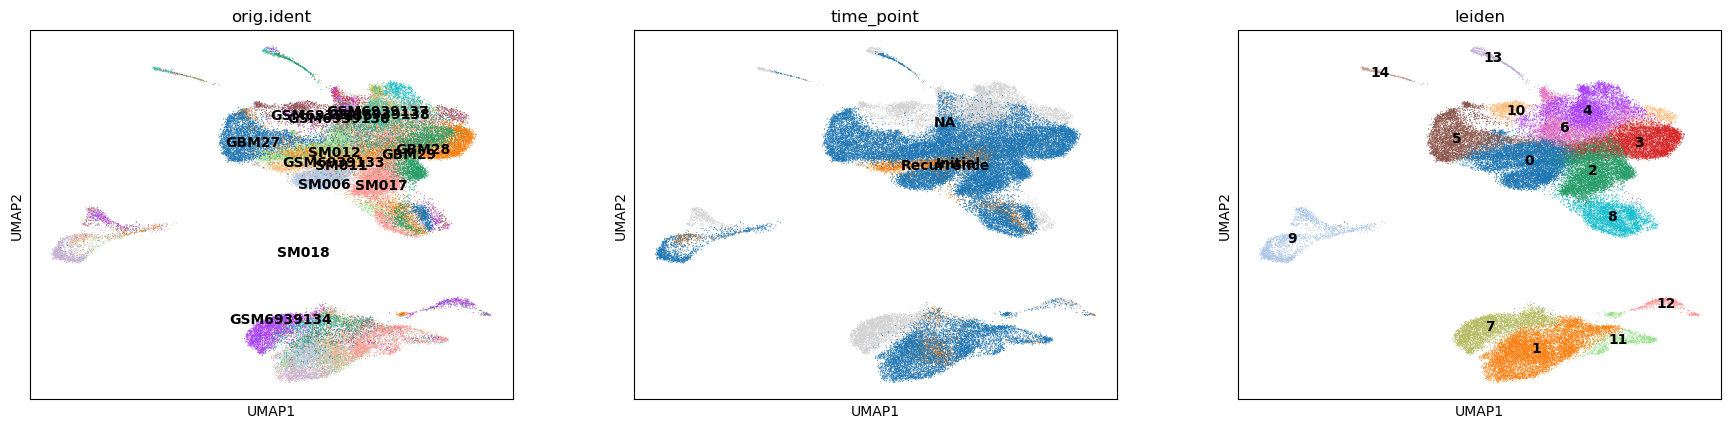

In [42]:
sc.pl.umap(adata, color=['orig.ident','time_point', 'leiden'],legend_loc='on data')

running Leiden clustering
    finished: found 16 clusters and added
    'leiden_R1', the cluster labels (adata.obs, categorical) (0:00:00)
Updated clusters under `adata_redux.obs['leiden_R1']`.


/tmp/ipykernel_43793/4037218926.py:47: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  new_df.cat.reorder_categories(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


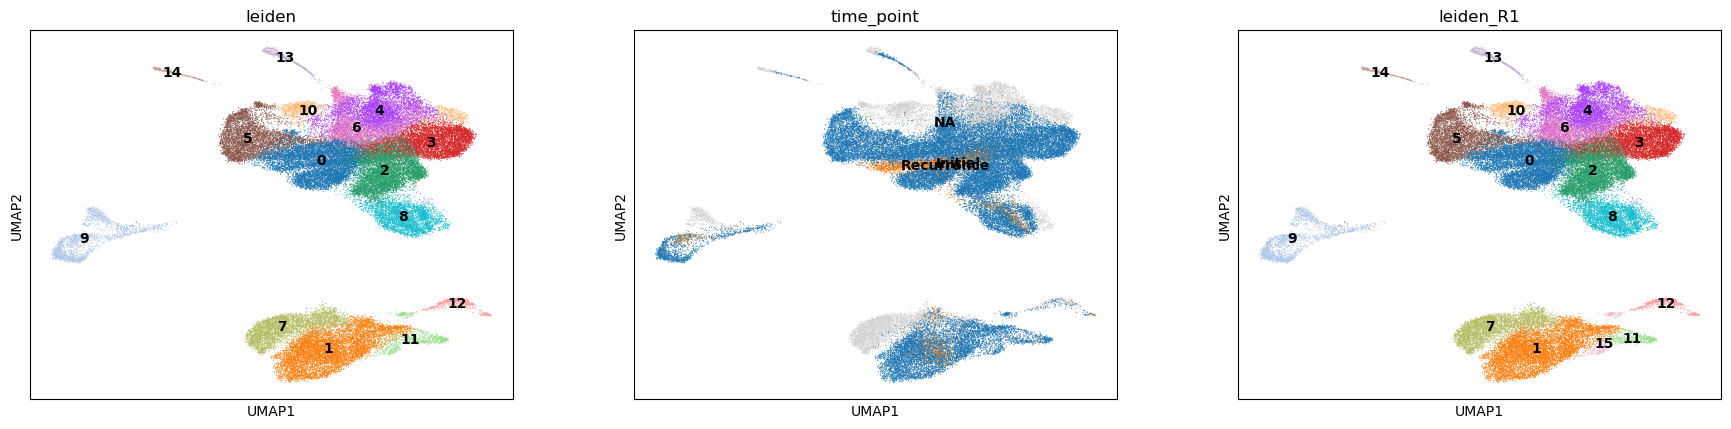

In [46]:
#细分亚群作图#
subcluster(adata_filt=adata, cluster="11", resolution=0.1, cluster_key="leiden")
sc.pl.umap(adata, color=['leiden','time_point', 'leiden_R1'], legend_loc='on data')
#


running Leiden clustering
    finished: found 17 clusters and added
    'leiden_R2', the cluster labels (adata.obs, categorical) (0:00:00)
Updated clusters under `adata_redux.obs['leiden_R2']`.


/tmp/ipykernel_43793/4037218926.py:47: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  new_df.cat.reorder_categories(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


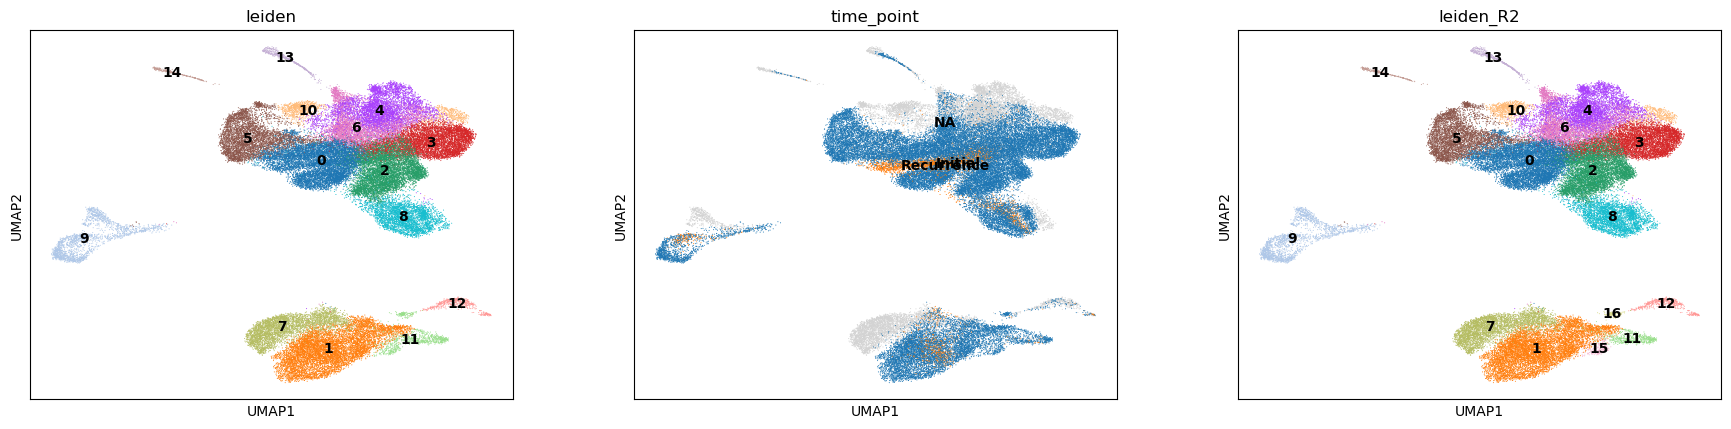

In [47]:
subcluster(adata_filt=adata, cluster="15", resolution=0.1, cluster_key="leiden_R1")
sc.pl.umap(adata, color=['leiden','time_point', 'leiden_R2'], legend_loc='on data')

running Leiden clustering
    finished: found 18 clusters and added
    'leiden_R3', the cluster labels (adata.obs, categorical) (0:00:00)
Updated clusters under `adata_redux.obs['leiden_R3']`.


/tmp/ipykernel_43793/4037218926.py:47: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  new_df.cat.reorder_categories(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


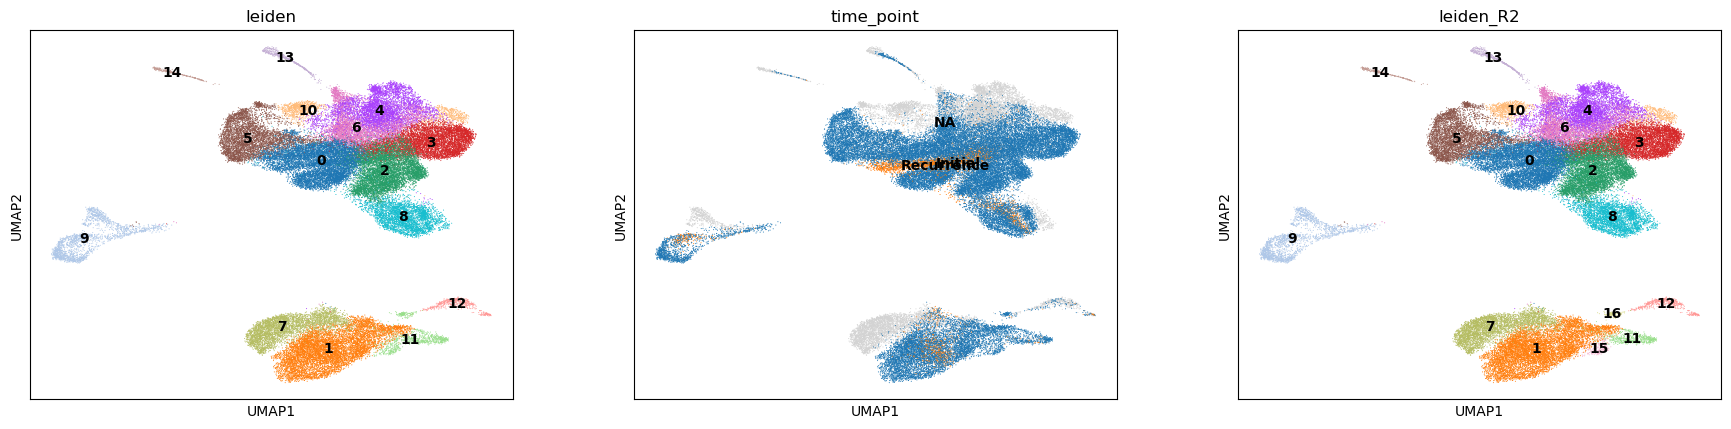

In [51]:
subcluster(adata_filt=adata, cluster="14", resolution=0.1, cluster_key="leiden_R2")
sc.pl.umap(adata, color=['leiden','time_point', 'leiden_R2'], legend_loc='on data')

In [ ]:
sc.pl.umap(adata, color=['leiden','leiden_R1','leiden_R2'], legend_loc='on data')
#

In [37]:
adata

AnnData object with n_obs × n_vars = 80538 × 36596
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'case_barcode', 'case_sex', 'age_at_resection', 'tumor_location', 'laterality', 'time_point', 'idh_codel_subtype', 'who_grade', 'histological_classification', 'cells_sc_10X', 'cells_sc_rrbs', 'mnp_classification_epic', 'verhaak_classification_rna', 'mutations_per_megabase', 'somatic_copy_number_alt_burden', 'driver_mutations', 'cell_name', 'sample', 'patient', 'reg_stg', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'leiden_R1', 'leiden_R2'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'hemoglobin', 'mitochondrial', 'mean', 'std'
    uns: 'case_barcode_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'orig.ident_colors', 'time_point_colors', 'leiden_colors', 'leiden_R1_colors', 'leiden_R2_colo

In [50]:
# Transfer h5ad to Seurat Obj

import numpy as np
import pandas as pd
import scanpy as sc
import diopy

# Load data
#adata = sc.read_h5ad("/media/4T_disk/scRNA_10X_data_human/10X_human_T_merge/data/BBKNN_scRNAseq_tumor_Verhaak_GSE139448_GSE173278_with_meta.h5ad")

# Export
diopy.output.write_h5(adata, 
                      file = '/media/4T_disk/scRNA_10X_data_human/10X_human_T_merge/data/merge/BBKNN_scobj_GSE139448_verhaak_GSE223063_with_meta.h5', 
                      save_X=False)

In [65]:
# 保存数据
adata
results_file = '/media/4T_disk/scRNA_10X_data_human/10X_human_T_merge/data/BBKNN_scRNAseq_tumor_Verhaak_GSE139448_GSE173278_with_meta.h5ad'
adata.write(results_file)

#保存UMAP坐标
cord_name='X_umap'
cord=pd.DataFrame(data=adata.obsm[cord_name],index=adata.obs_names,columns=['umap_x','umap_y'])
cord.to_csv('/media/4T_disk/scRNA_10X_data_human/10X_human_T_merge/data/Verhaak_GSE139448_GSE173278_position_X_umap.csv')

obs_df = pd.DataFrame(adata.obs)
obs_df.to_csv('/media/4T_disk/scRNA_10X_data_human/10X_human_T_merge/data/Verhaak_GSE139448_GSE173278_obs_info.csv')

## Harmony合并#######二选一##################################
# adata_concat=adata
# sc.tl.pca(adata_concat)
# sc.external.pp.harmony_integrate(adata_concat, key='case_barcode')
# 计算邻域图。umap降维
# pcs_num=50
# neighbor_num=33
# sc.pp.neighbors(adata_concat,use_rep='X_pca_harmony',n_neighbors=neighbor_num, n_pcs=pcs_num)
# sc.tl.umap(adata_concat)
# sc.tl.leiden(adata,resolution=5)
# sc.pl.umap(adata, color=['case_barcode','cell_state', 'leiden'], legend_loc='on data')

In [48]:
gene_list = {
  "Astro" : ["GFAP","ALDH1L1","SLC1A3"],
  "Oligo" : ["MBP", "MOG"],
  "Neu" : ["NRCAM","NCAM2","SHISA9"],
  "Endo" : [ 'VWF',"CD34",'SLC2A1'],
  "Peri" : ["MYO1B","PDGFRB","MCAM"],
  "CAFs": ['COL3A1','FBN1', 'LUM'],
  "Mic" : ["TREM2", "C1QA", "TYROBP","AIF1"],
  "Mac" : ["ITGAL","FCER1G","CSF1R",'CD14'],
  "DC": ["CD1C", "CD1E", "CLEC10A"],                                   #ITGAX为CD11c
  "Mono_CD16_Neg" :["CD93", "ITGA5","TREM1"],
  "Mono_CD16_pos" :["FCGR3A"],
  "T_cell" : ['CD3D', 'CD3E', 'CD4','CD8A',"FOXP3"],
  "B_cell" : ["CD19", "MS4A1", "BANK1"],
  "GSCs" : ['NES',"SOX2","SOX11","TCF12"],
  "Prolif_like" : ["MKI67"]}

/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


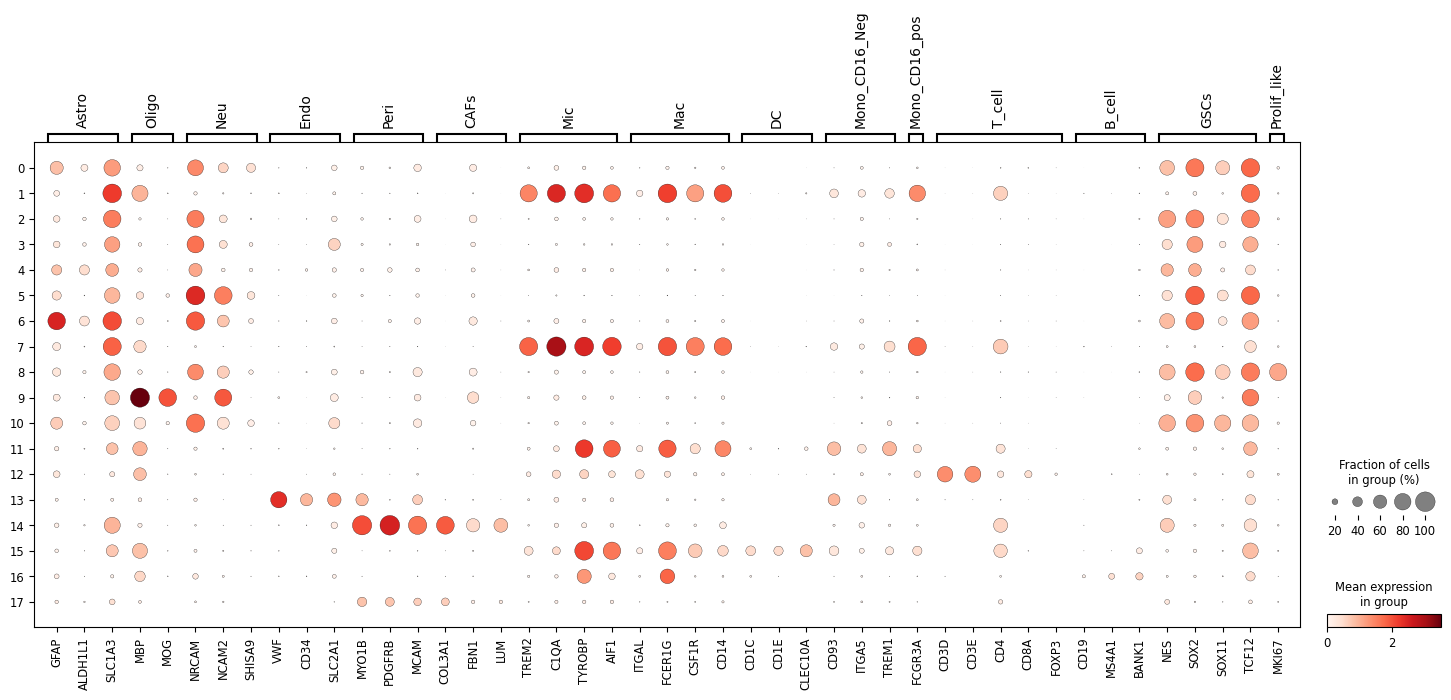

/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangyufan/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


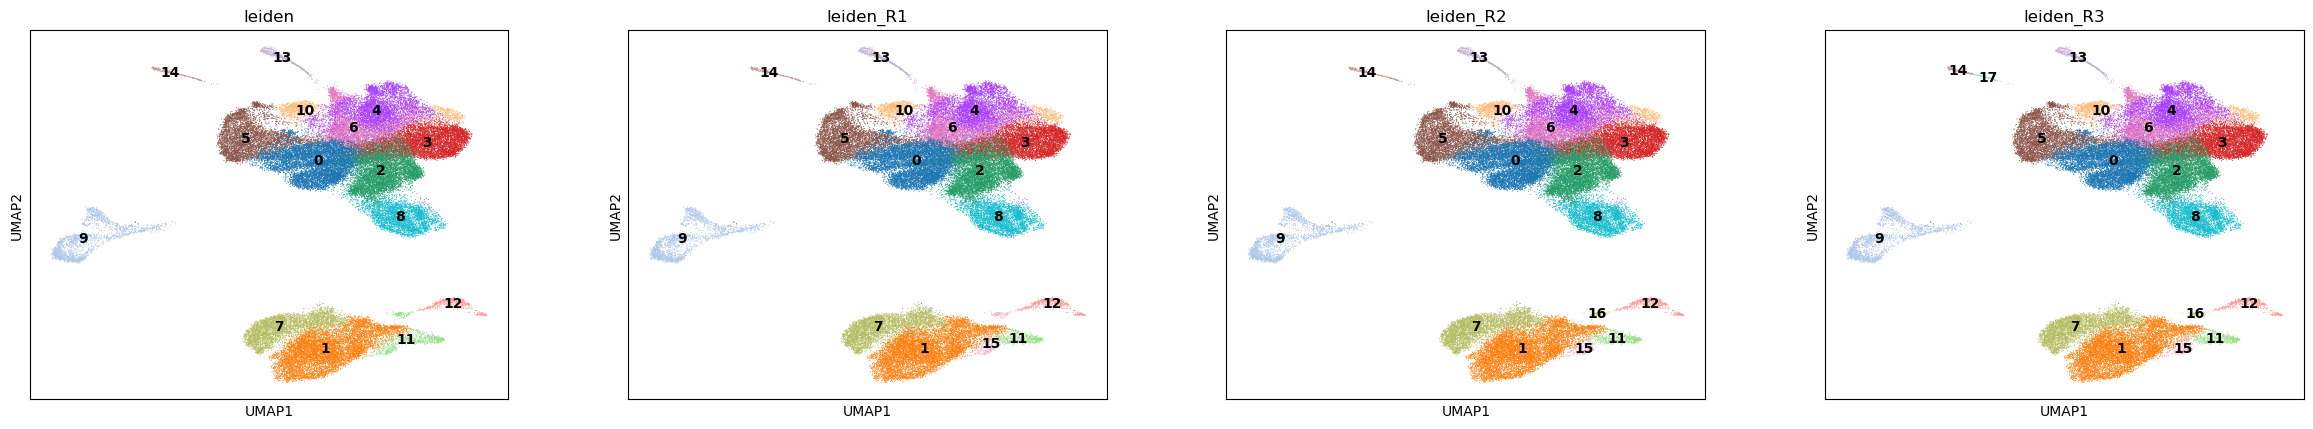

In [53]:
sc.pl.dotplot(adata, gene_list, groupby='leiden_R3')
sc.pl.umap(adata, color=['leiden','leiden_R1','leiden_R2','leiden_R3'], legend_loc='on data')

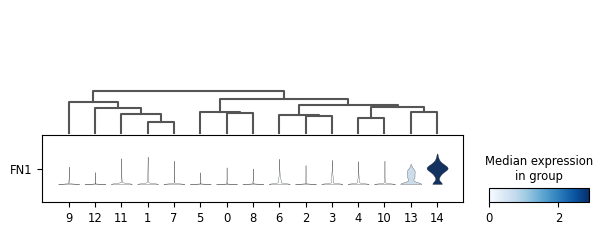

In [39]:
sc.pl.stacked_violin(adata, "FN1", groupby='leiden', swap_axes=True,dendrogram=True)

In [30]:
adata.obs.value_counts("time_point")

time_point
Initial       71262
Recurrence     9276
dtype: int64